First at all, we need to install module gymnasium for dealing with the enviroment of the RL algorithm  we are going to code.

In [4]:
!pip install gymnasium

Then, we import several auxiliar modules useful to write the code.

In [5]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

Maybe we can use some cuda (or not)

In [6]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


Ant then, load the enviroment of cart-pole

In [7]:
env = gym.make("CartPole-v1")

We need to save some past completed transitions, so the above code allow us to storage them

In [8]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
    def push(self, *args):
        self.memory.append(Transition(*args))
    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)
    def __len__(self):
        return len(self.memory)

The calculation of the Q table is done by using a neural network in pytorch. Let define a class for a neural network:

In [9]:
class DQN(nn.Module):
    """
    Args:
        n_observations: observation/state size of the environment
        n_actions: number of discrete actions available in the environment
        hidden_size: size of the hidden layers
    """
    def __init__(self, n_observations, n_actions, hidden_size):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, hidden_size)
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, n_actions)
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

Some hyperparameters must be a value to be assigned

In [10]:
BATCH_SIZE = 128
GAMMA = 0.99
EPSILON_START = 0.9
EPSILON_END = 0.05
EPSILON_DECAY = 1000
TAU = 0.005
LR = 1e-4
HIDDEN_SIZE = 128

Our agent are going to use epsilon-greedy poliy to choose the next action to take

In [11]:
def choose_action(state):
    global steps_done
    sample = random.random()
    epsilon_threshold = EPSILON_END + (EPSILON_START - EPSILON_END) * math.exp(-1. * steps_done / EPSILON_DECAY)
    steps_done += 1
    if sample > epsilon_threshold:
        # max(1) will return largest column value of each row
        # second column on max result is index of where max element was found
        # so we pick action with the larger expected reward
        with torch.no_grad():
            return policy_network(state).max(1)[1].view(1,1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype= torch.long)

This neural network must be optimized (by means of a kind of gradient descent algorithm every BATCH transitions)

In [12]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transition = memory.sample(BATCH_SIZE)
    # Transpose the batch and convert the batch-array of Transition
    #   to Transition of batch-arrays
    batch=Transition(*zip(*transition))
    # Compute a mask of non-final states and concatenate the batch element
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), device=device, dtype= torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                       if s is not None])
    state_batch=torch.cat(batch.state)
    action_batch=torch.cat(batch.action)
    reward_batch=torch.cat(batch.reward)
    # Compute Q(s_t, a)
    #   These are the actions which would have been taken
    #       for each batch according to policy_net
    state_action_values = policy_network(state_batch).gather(1, action_batch)
    # Compute V(S_{t+1} for all next states
    #    Expected values of actions for non_final_next_states are computed based
    #        on the "older" target_net; selecting their best reward with max(1)[0]
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_network(non_final_next_states).max(1)[0]
        # Compute the expected Q values
    expected_state_action_values = reward_batch + (GAMMA * next_state_values)

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()

    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_network.parameters(), 100)
    optimizer.step()

An auxiliar function is defined to deal with the plots about the process of learning in the episodies performed

In [13]:
'''
Function to plot the durations of episodes,
along with an average over the last 100 episodes
'''
def plot_scores(show_result= False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype= torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training ...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Tale 100 episode averages and plt them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())
    plt.pause(0.001)
    if not show_result:
        display.display(plt.gcf())
        display.clear_output(wait=True)
    else:
        display.display(plt.gcf())

And finally, the core instructions for this example is given bellow

Complete


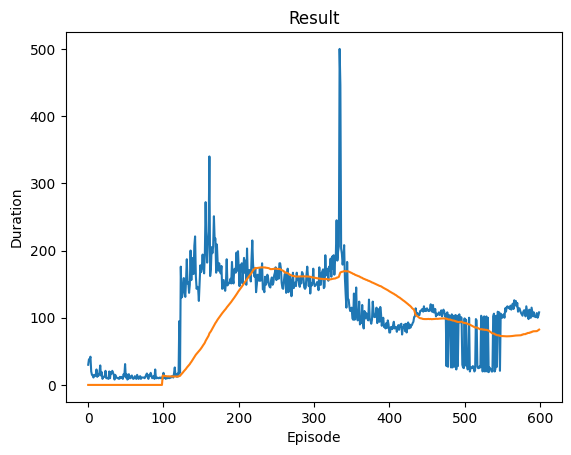

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
n_actions = env.action_space.n
print('n_actions: ', n_actions)
state, info = env.reset()
n_observations = len(state)
print('state: ', state)
print('n_observatioms: ', n_observations)
policy_network = DQN(n_observations, n_actions, HIDDEN_SIZE).to(device)
target_network = DQN(n_observations, n_actions, HIDDEN_SIZE).to(device)
#updates the parameters of the target_network with the parameters of the policy_network
target_network.load_state_dict(policy_network.state_dict())

optimizer = optim.AdamW(policy_network.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)
steps_done = 0
episode_durations = []
if torch.cuda.is_available():
    num_episodes = 600
else:
    num_episodes = 600
for i_episode in range(num_episodes):
    # At the beginning we reset the environment and initialize the state Tensor
    state, info = env.reset()
    # print(state)
    state = torch.tensor(state, dtype=torch.float32, device= device).unsqueeze(0)
    total_reward = 0
    for t in count():  # infinite loop until breaking because done is True
        # sample an action
        action = choose_action(state)
        # execute it.observe the next screen and the reward
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the experience in the memory
        memory.push(state, action, next_state, reward)

        # move to the mext state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        # The agent performs an optimization step on the Policy Network using the stored memory
        optimize_model()
        '''
        The agent will perform a soft update fo the Target Network's weights,
        with the equation TAU ? policy_net_state_dict + (1-TAU) * target_net_state_dict,
        this helps to make the Target Network's weights converge to the POlicy Network's weights
        '''
        # Soft update of the target network's weights
        # Theta' = TAU * Theta + (1-TAU) * theta'
        # policy_network_state_dict() returns the parameters of the policy network
        # target_network.load_state_dict() loads these parameters into the target network
        target_net_state_dict = target_network.state_dict()
        policy_net_state_dict = policy_network.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_network.load_state_dict(target_net_state_dict)
        total_reward += reward
        if done:
            episode_durations.append(t+1)
            print("Episode", i_episode, "Game terminated after",t, "steps with reward", total_reward)
            plot_scores()
            break

print("Complete")
plot_scores(show_result=True)
plt.ioff()
plt.show()